# 타이타닉 데이터를 활용한 데이터 분석

* 어떤 종류의 사람들이 많이 살아남았는지에 대한 분석을 해야 합니다. 머신러닝을 이용해 어떤 승객이 생존했을지 예측해보세요. 

## 라이브러리, 데이터셋 불러오기

In [52]:
import pandas as pd
from sklearn.linear_model import LogisticRegression    # 로지스틱 회귀 모델 불러오기
from sklearn.tree import DecisionTreeClassifier    # 의사결정 나무 모델 불러오기

In [53]:
train = pd.read_csv('train.csv')    # 모델 학습 파일 불러오기
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## EDA

In [54]:
train.head(3)
test.head(3)
# test 데이터셋은 생존여부 주어지지 않았음 확인.

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [55]:
train.info()
test.info()
# train 셋의 Age, Cabin, Embarked 칼럼에 결측치 존재함을 확인
# test 셋의 Age,Fare, Cabin 칼람에 결측치 존재함을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [56]:
train.describe()

# Survied 의 mean통계량은 생존률을 의미한다.
# 잘 생각해보면... 0과 1로 기록된 Survied의 값들을 모두 더하면 생존 인원수를 의미함.
# 생존 인원수를 전체 탑승객수인 891로 나누면 생존률을 뜻한다.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [57]:
# Series 내 고유값들과 개수를 보여주는 함수들 (참고로 알아두자.)
# train['Embarked'].value_counts()
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [58]:
train.groupby('Sex').mean()
train.groupby('Pclass').mean()
train.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


### 막대그래프 시각화 

<AxesSubplot:xlabel='Pclass'>

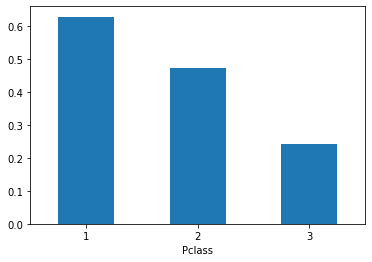

In [59]:
train.groupby('Pclass').mean()['Survived'].plot(kind = 'bar', rot = 0)

### 히스토그램 시각화 
* 수치형 컬럼의 전반적인 분포 확인

<AxesSubplot:ylabel='Frequency'>

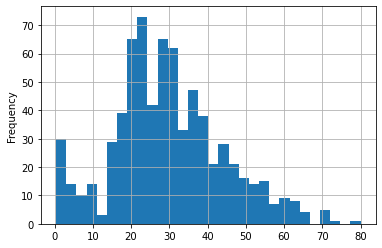

In [60]:
train['Age'].plot(kind = 'hist', bins = 30, grid = True)

### 산점도 시각화 
* 두 변수간의 관계를 시각화

<AxesSubplot:xlabel='Age', ylabel='Fare'>

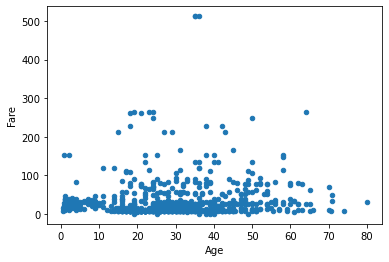

In [61]:
train.plot(x = 'Age', y = 'Fare', kind = 'scatter')

## 데이터 전처리

In [62]:
train.isna().sum()    # 컬럼별 true 값(결측치)을 1로 반환하여 더함.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

● 결측치에 각각 중앙값, 최빈값, 평균값 등으로 채워넣음.

In [63]:
train['Age'].median()    # 중앙값
train['Embarked'].value_counts()    # 최빈값

train['Age'] = train['Age'].fillna(28)   
train['Embarked'] = train['Embarked'].fillna('S')

In [64]:
train['Sex'] = train['Sex'].map({'male':0, 'female':1})    # map 함수를 통해 male과 female을 0과 1로 수치화 시킴. (모델링을 위함)

## 모델링

* X -> MODEL -> y
* 탑승객의 인적 정보를 MODEL에 입력 -> 탑승객의 생존확률을 y에 입력.
* MODEL에 입력할 컬럼을 정해야함.
* Sex, Pclass 를 사용 할 것임.

* 모델을 구축하고 평가할 데이터프레임을 모두 만들어줌

In [65]:
X_train = train[['Sex', 'Pclass']]    # 두개의 컬럼만 넣은 새로운 DF
y_train = train['Survived']    # Survived (생존유무) 만 넣을 DF

In [72]:
test['Sex'] = test['Sex'].map({'male':0, 'female':1})    # test 데이터셋도 마찬가지로 male과 female을 0과 1로 수치화 시킴.
X_test = test[['Sex', 'Pclass']]

In [73]:
lr = LogisticRegression()    
dt = DecisionTreeClassifier()

* model.fit() 을 통해 lr, dt 모델을 학습 시킬 수 있음.

In [74]:
lr.fit(X_train, y_train)    # 주어진 데이터셋에 맞게 모델을 변형시킴.
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [75]:
lr.predict(X_test)    # 모델 학습 후 예측된 데이터 확인할 수 있음.

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [79]:
lr.predict_proba(X_test)    # 사망확률, 생존확률 두가지로 나타냄. 내가 원하는 확률은 생존확률. 2번째 열들이다.

lr_pred = lr.predict_proba(X_test)[:,1]    # 두번째 열들만 뽑아서 넣어줌.
dt_pred = dt.predict_proba(X_test)[:,1]    # dt모델에도 모델링된 데이터를 넣어줌.

In [82]:
# submission 파일에 예측한 결과 저장

submission['Survived'] = lr_pred
submission.to_csv('lr_pred.csv', index = False)

submission['Survived'] = dt_pred
submission.to_csv('dt_pred.csv', index = False)